<a href="https://colab.research.google.com/github/shethshaurya/Coursera_Capstone/blob/master/Assignment17_FB_Friend_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
!unzip "/content/drive/My Drive/data/Facebook-20200901T212013Z-001.zip"

Archive:  /content/drive/My Drive/data/Facebook-20200901T212013Z-001.zip
replace Facebook/FB_Models.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Facebook/FB_Models.ipynb  
replace Facebook/FB_EDA.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Facebook/FB_EDA.ipynb   
replace Facebook/FB_featurization.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Facebook/FB_featurization.ipynb  
replace Facebook/data/test_y.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Facebook/data/test_y.csv  
replace Facebook/data/train_y.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Facebook/data/train_y.csv  
replace Facebook/data/fea_sample/storage_sample_stage2.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Facebook/data/fea_sample/storage_sample_stage2.h5  
replace Facebook/data/after_eda/test_neg_after_eda.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Facebook/data/after_eda/test_neg_after_eda.csv  
replace Facebook/data/fe

In [37]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [38]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('/content/Facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/Facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [39]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [40]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [41]:
df_final_train_t1 = df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1)
df_final_test_t1 = df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1)

Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

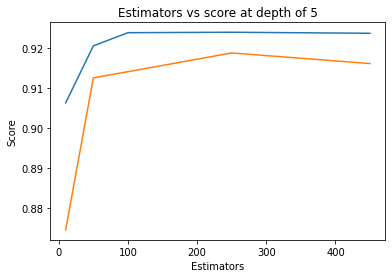

In [42]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train_t1,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train_t1))
    test_sc = f1_score(y_test,clf.predict(df_final_test_t1))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8929662966191592 test Score 0.8671992440836661
depth =  9 Train Score 0.9583995436580695 test Score 0.9246768557113384
depth =  11 Train Score 0.96189219368592 test Score 0.9252161474220081
depth =  15 Train Score 0.9637507611122388 test Score 0.9264916266935959
depth =  20 Train Score 0.9638277783981888 test Score 0.9267656036206715
depth =  35 Train Score 0.9638419684911482 test Score 0.9268590431689504
depth =  50 Train Score 0.9638419684911482 test Score 0.9268590431689504
depth =  70 Train Score 0.9638419684911482 test Score 0.9268590431689504
depth =  130 Train Score 0.9638419684911482 test Score 0.9268590431689504


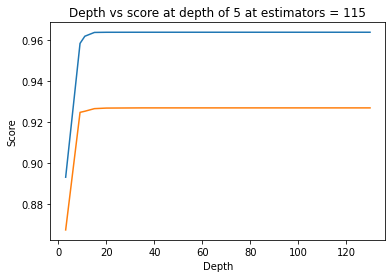

In [44]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=265, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train_t1,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train_t1))
    test_sc = f1_score(y_test,clf.predict(df_final_test_t1))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [45]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(250,300),
              "max_depth": sp_randint(20,35),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score =True)

rf_random.fit(df_final_train_t1,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96295253 0.96372767 0.96278719 0.96414528 0.96428167]
mean train scores [0.96361105 0.96480418 0.96327206 0.96510947 0.96578263]


In [46]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=24, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=272,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [47]:
clf_best = rf_random.best_estimator_

In [49]:
clf_best.fit(df_final_train_t1,y_train)
y_train_pred = clf_best.predict(df_final_train_t1)
y_test_pred = clf_best.predict(df_final_test_t1)

In [50]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9659199189052206
Test f1 score 0.9273703041144902


In [51]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


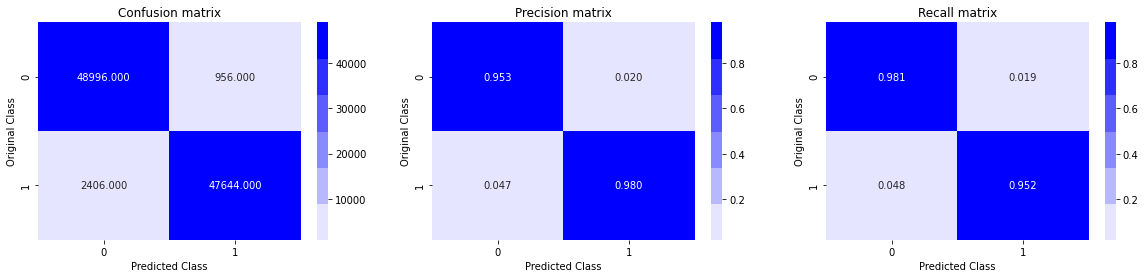

Test confusion_matrix


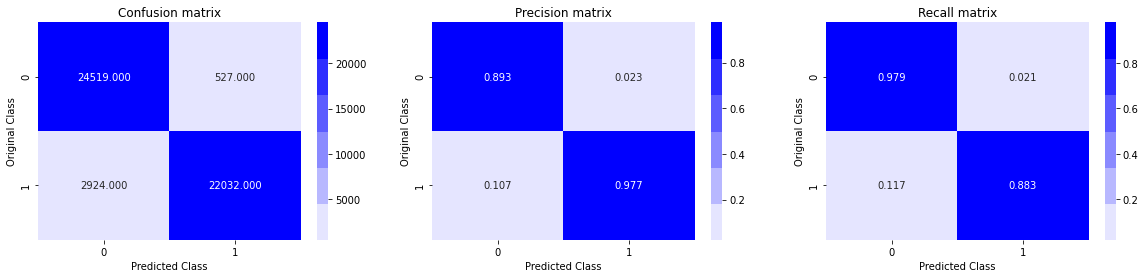

In [52]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

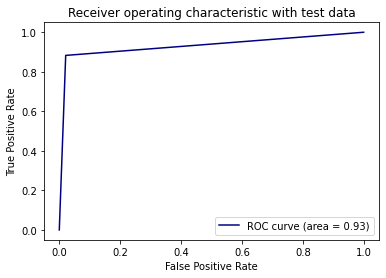

In [53]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

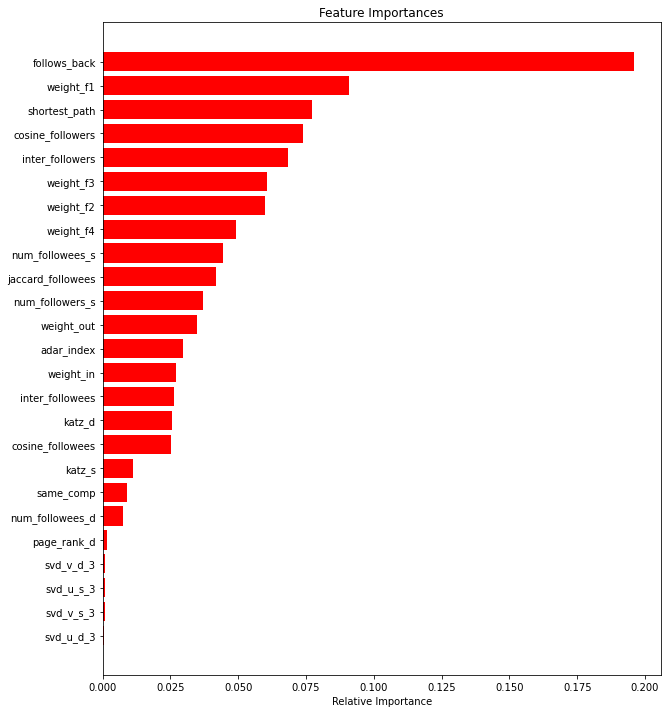

In [55]:
features = df_final_train_t1.columns
importances = clf_best.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

##Task 1

In [56]:
if os.path.isfile('/content/Facebook/data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [57]:
def compute_preferential_attach(df_final):
    #calculating the multiplication of length of followers and followees for source and destination
    pa_followers=[]
    pa_followees=[]

    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        pa_followers.append(len(s1)*len(d1))

        pa_followees.append(len(s2)*len(d2))

    
    return pa_followers, pa_followees

In [58]:
if os.path.isfile('/content/Facebook/data/fea_sample/storage_sample_stage4.h5'):
    df_final_train['pa_followers'], df_final_train['pa_followees']= compute_preferential_attach(df_final_train)
    
    df_final_test['pa_followers'], df_final_test['pa_followees']= compute_preferential_attach(df_final_test)
    
    hdf = HDFStore('/content/Facebook/data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

##Task 2

Creating a new feature which are the dot product of these svd features i.e. 

svd_u_s_1*svd_u_d_1 + svd_u_s_2*svd_u_d_2 + svd_u_s_3*svd_u_d_3 ... svd_u_s_6*svd_u_d_6

Creating another feature which are the dot product of destination features also

(svd_v_s_1*svd_v_d_1 + svd_v_s_2*svd_v_d_2 + svd_v_s_3*svd_v_d_3 ... svd_v_s_6*svd_v_d_6)

In [59]:
df_final_train['svd_dot_1']= (df_final_train['svd_u_s_1']*(df_final_train['svd_u_d_1'])) + (df_final_train['svd_u_s_2']*(df_final_train['svd_u_d_2'])) + \
                             (df_final_train['svd_u_s_3']*(df_final_train['svd_u_d_3'])) + (df_final_train['svd_u_s_4']*(df_final_train['svd_u_d_4'])) + \
                             (df_final_train['svd_u_s_5']*(df_final_train['svd_u_d_5'])) + (df_final_train['svd_u_s_6']*(df_final_train['svd_u_d_6']))

In [60]:
df_final_train['svd_dot_2']= (df_final_train['svd_v_s_1']*(df_final_train['svd_v_d_1'])) + (df_final_train['svd_v_s_2']*(df_final_train['svd_v_d_2'])) + \
                             (df_final_train['svd_v_s_3']*(df_final_train['svd_v_d_3'])) + (df_final_train['svd_v_s_4']*(df_final_train['svd_v_d_4'])) + \
                             (df_final_train['svd_v_s_5']*(df_final_train['svd_v_d_5'])) + (df_final_train['svd_v_s_6']*(df_final_train['svd_v_d_6']))

In [61]:
df_final_test['svd_dot_1']= (df_final_test['svd_u_s_1']*(df_final_test['svd_u_d_1'])) + (df_final_test['svd_u_s_2']*(df_final_test['svd_u_d_2'])) + \
                             (df_final_test['svd_u_s_3']*(df_final_test['svd_u_d_3'])) + (df_final_test['svd_u_s_4']*(df_final_test['svd_u_d_4'])) + \
                             (df_final_test['svd_u_s_5']*(df_final_test['svd_u_d_5'])) + (df_final_test['svd_u_s_6']*(df_final_test['svd_u_d_6']))

In [62]:
df_final_test['svd_dot_2']= (df_final_test['svd_v_s_1']*(df_final_test['svd_v_d_1'])) + (df_final_test['svd_v_s_2']*(df_final_test['svd_v_d_2'])) + \
                             (df_final_test['svd_v_s_3']*(df_final_test['svd_v_d_3'])) + (df_final_test['svd_v_s_4']*(df_final_test['svd_v_d_4'])) + \
                             (df_final_test['svd_v_s_5']*(df_final_test['svd_v_d_5'])) + (df_final_test['svd_v_s_6']*(df_final_test['svd_v_d_6']))

In [63]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'pa_followers', 'pa_followees', 'svd_dot_1', 'svd_dot_2'],
      dtype='object')

##Task 3

In [64]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [65]:
df_final_train_t2 = df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1)
df_final_test_t2  = df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1)

In [66]:
!pip install xgboost

In [67]:
import xgboost as xgb

Estimators =  10 Train Score 0.9210492696844526 test Score 0.9162413689582708
Estimators =  50 Train Score 0.9675354922332259 test Score 0.9231354642313546
Estimators =  100 Train Score 0.9736268857840504 test Score 0.9281594571670908
Estimators =  250 Train Score 0.9779501631263698 test Score 0.9152513258755074
Estimators =  450 Train Score 0.9824526059189717 test Score 0.9005723238961547


Text(0.5, 1.0, 'Estimators vs score at depth of 3')

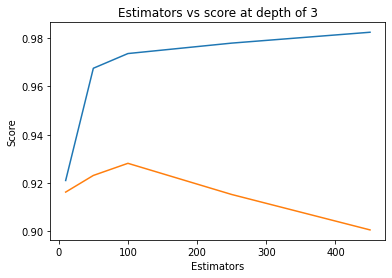

In [69]:
#applying decision tree on the basic of grid search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_scores_t2 =[]
test_scores_t2  =[]
parameters_ne = [10,50,100,250,450]
for i in parameters_ne:

    clf_t2 = xgb.XGBClassifier(n_estimators=i, n_jobs=-1)
    clf_t2.fit(df_final_train_t2,y_train)
    train_sc_t2 = f1_score(y_train,clf_t2.predict(df_final_train_t2))
    test_sc_t2 = f1_score(y_test,clf_t2.predict(df_final_test_t2))
    test_scores_t2.append(test_sc_t2)
    train_scores_t2.append(train_sc_t2)
    print('Estimators = ',i,'Train Score',train_sc_t2,'test Score',test_sc_t2)
plt.plot(parameters_ne,train_scores_t2,label='Train Score')
plt.plot(parameters_ne,test_scores_t2,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 3')


In [70]:
#applying decision tree on the basic of grid search
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_scores_t2 =[]
test_scores_t2  =[]
parameters_md = [3,9,11,15,20,35,50,70,130]
for i in parameters_md:

    clf_t2 = xgb.XGBClassifier(n_estimators=100, max_depth = i , n_jobs=-1)
    clf_t2.fit(df_final_train_t2,y_train)
    train_sc_t2 = f1_score(y_train,clf_t2.predict(df_final_train_t2))
    test_sc_t2 = f1_score(y_test,clf_t2.predict(df_final_test_t2))
    test_scores_t2.append(test_sc_t2)
    train_scores_t2.append(train_sc_t2)
    print('Depth = ',i,'Train Score',train_sc_t2,'test Score',test_sc_t2)



Depth =  3 Train Score 0.9736268857840504 test Score 0.9281594571670908
Depth =  9 Train Score 0.9872526234241848 test Score 0.9299300995551789
Depth =  11 Train Score 0.9928021442984349 test Score 0.9268075167215203
Depth =  15 Train Score 0.999730196956222 test Score 0.9270227841656413
Depth =  20 Train Score 1.0 test Score 0.9294266976940977
Depth =  35 Train Score 1.0 test Score 0.9309484544801049
Depth =  50 Train Score 1.0 test Score 0.9310024098423033
Depth =  70 Train Score 1.0 test Score 0.9310024098423033
Depth =  130 Train Score 1.0 test Score 0.9310024098423033


Text(0.5, 1.0, 'Depth vs score at estimators of 100')

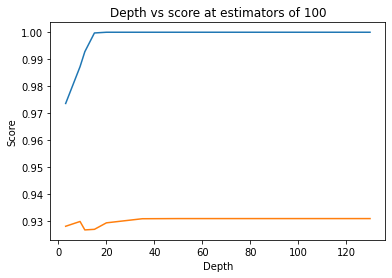

In [115]:
plt.plot(parameters_md,train_scores_t2,label='Train Score')
plt.plot(parameters_md,test_scores_t2,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators of 100')


In [71]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(95,135),
              "max_depth": sp_randint(40,55)}

clf_t2 = xgb.XGBClassifier(random_state=25,n_jobs=-1)

xg_random_t2 = RandomizedSearchCV(clf_t2, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score =True)

xg_random_t2.fit(df_final_train_t2,y_train)
print('mean test scores',xg_random_t2.cv_results_['mean_test_score'])
print('mean train scores',xg_random_t2.cv_results_['mean_train_score'])

mean test scores [0.97928118 0.97929972 0.9788908  0.9787006  0.97939296]
mean train scores [1. 1. 1. 1. 1.]


In [72]:
print(xg_random_t2.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=49,
              min_child_weight=1, missing=None, n_estimators=126, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [73]:
clf_t2_best = xg_random_t2.best_estimator_

In [75]:
clf_t2_best.fit(df_final_train_t2,y_train)
y_train_pred = clf_t2_best.predict(df_final_train_t2)
y_test_pred = clf_t2_best.predict(df_final_test_t2)

In [76]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9290841715193224


In [77]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


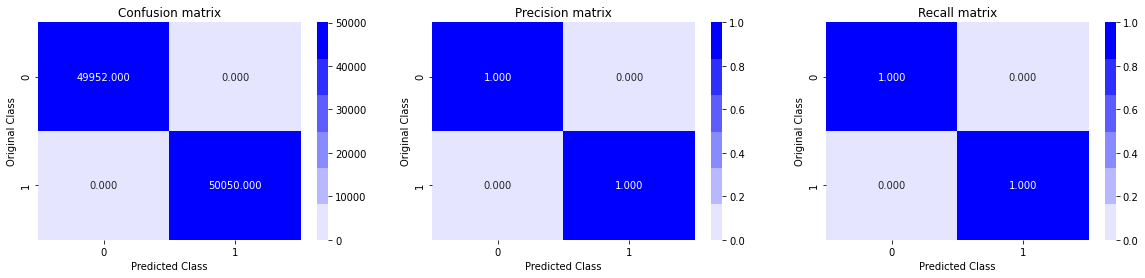

Test confusion_matrix


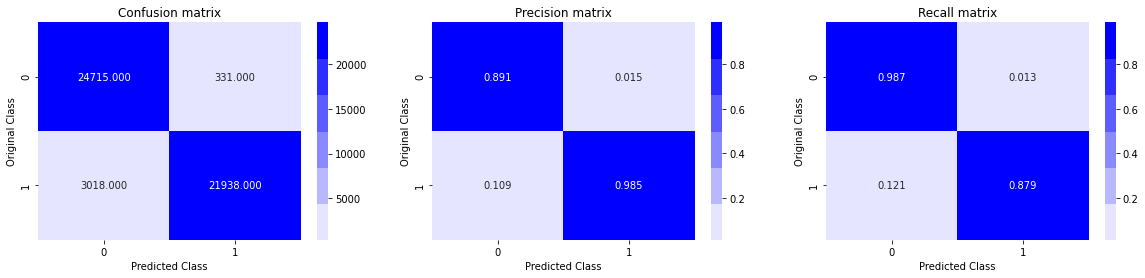

In [78]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

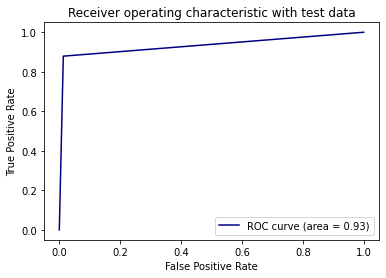

In [79]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

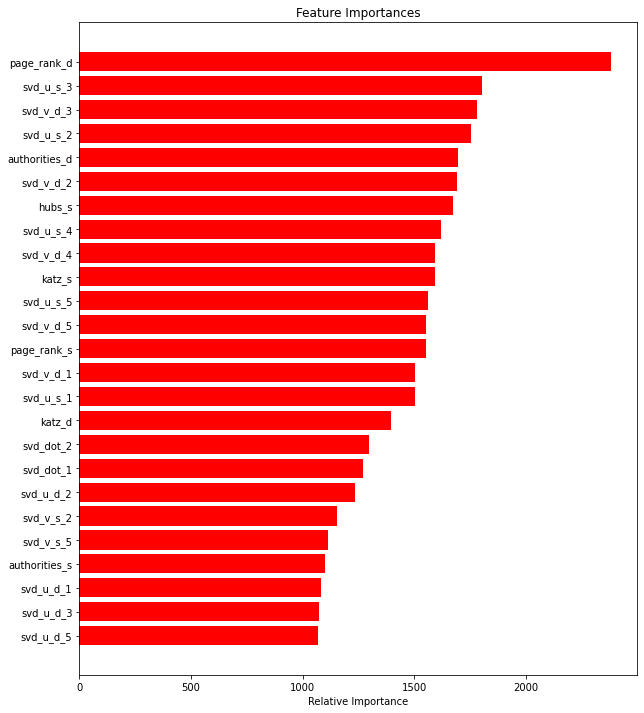

In [109]:
feature_important = clf_t2_best.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
indices = list((np.argsort(values)))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), [values[int(i)] for i in indices], color='r', align='center')
plt.yticks(range(len(indices)), [keys[int(i)] for i in indices])
plt.xlabel('Relative Importance')
plt.show()